To open on Google Colab\
https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week5/gpytorch_h3o_pes_CUDA.ipynb

In [1]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To enable GPU hardware accelerator, just go to\
 **Runtime -> Change runtime type -> Hardware accelerator -> GPU**

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
cuda0 = torch.device('cuda:0')

True
Tesla T4


## Homework!
Fit the H3O+ PES.

```python
#load data
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/main/Course_Notes/data/h3o+"
data = pd.read_csv(data_url)
```

**References**:\
[Assessing Gaussian Process Regression and Permutationally Invariant Polynomial Approaches To Represent High-Dimensional Potential Energy Surfaces](https://pubs.acs.org/doi/10.1021/acs.jctc.8b00298)


https://docs.gpytorch.ai/en/stable/


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#load data
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/main/Course_Notes/data/h3o+"
data = pd.read_csv(data_url)
print(data.head)

Xtot = data.drop(['Energy'],axis=1).to_numpy()
ytot = data['Energy'].to_numpy()#[:,np.newaxis]

# data            
N = 500
Nval = 250 
X_train,X_test,y_train,y_test = train_test_split(Xtot,ytot,test_size=ytot.shape[0] - N,random_state=0)
X_test, y_test = X_test[:Nval],y_test[:Nval]
Xtr,Xtst,ytr,ytst = X_train,X_test,y_train,y_test


<bound method NDFrame.head of          R-H1H2    R-H1H3     R-H1O    R-H2H3     R-H2O     R-H3O    Energy
0      1.612409  1.619333  0.983016  1.620888  0.966339  0.974973  0.000160
1      1.608433  1.630167  0.981183  1.611739  0.986385  0.975660  0.000244
2      1.598165  1.612593  0.961918  1.612899  0.978415  0.970702  0.000252
3      1.624321  1.616543  0.975496  1.634513  0.991981  0.971806  0.000259
4      1.621266  1.627356  0.978769  1.620356  0.977598  0.993640  0.000290
...         ...       ...       ...       ...       ...       ...       ...
32136  1.708361  2.239641  1.194543  2.136567  1.009856  1.318925  0.095581
32137  2.023008  1.781084  0.957492  1.207863  1.098086  1.100776  0.095581
32138  2.083079  2.100782  1.261244  1.311036  0.914893  1.099041  0.095581
32139  1.850452  2.213210  1.416897  1.556157  1.008990  0.904831  0.095589
32140  1.816564  2.150869  1.034572  1.301846  0.927945  1.252055  0.095589

[32141 rows x 7 columns]>


(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 <a list of 10 Text major ticklabel objects>)

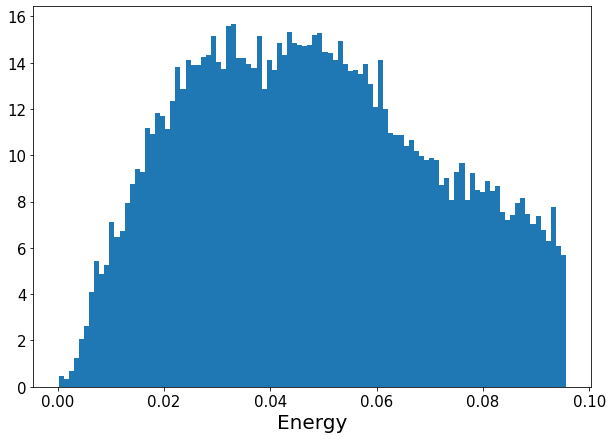

In [24]:
import matplotlib
import matplotlib.pylab as plt

plt.figure(figsize=(10,7))
plt.hist(data['Energy'],bins=100,density=True)
plt.xlabel('Energy',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## GPyTorch

In [28]:
import torch
import gpytorch

# from numpy to torch
Xtr = torch.from_numpy(Xtr).cuda()
ytr = torch.from_numpy(ytr).cuda()
Xtst = torch.from_numpy(Xtst).cuda()
ytst = torch.from_numpy(ytst).cuda()

Xtot = torch.from_numpy(Xtot)
ytot = torch.from_numpy(ytot)

In [20]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [29]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(Xtr, ytr, likelihood)

if torch.cuda.is_available():
  likelihood.cuda()
  model.cuda()

In [34]:
# Find optimal model hyperparameters using ADAM

# Use the adam optimizer
# Includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 150
mll_trajectory = []
mll_trajectory_tst = []
for i in range(training_iter):
    model.train()
    likelihood.train()
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(Xtr)
    # Calc loss and backprop gradients
    loss = -mll(output, ytr)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.6f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    print('lengthscale: ', model.covar_module.base_kernel.lengthscale[0])
    mll_trajectory.append(loss.item())
    optimizer.step()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        model.eval()
        likelihood.eval()
        ypred = likelihood(model(Xtst))
        mse = torch.sqrt(torch.sum((ypred.mean - ytst)**2))
        mll_trajectory_tst.append(mse.cpu())
        

Iter 1/150 - Loss: -3.352  noise: 0.000112
lengthscale:  tensor([1.0348, 1.1565, 0.4453, 1.0231, 0.4728, 0.4928], device='cuda:0',
       grad_fn=<SelectBackward0>)
Iter 2/150 - Loss: -3.365  noise: 0.000111
lengthscale:  tensor([0.9714, 1.0891, 0.4825, 0.9602, 0.4363, 0.4551], device='cuda:0',
       grad_fn=<SelectBackward0>)
Iter 3/150 - Loss: -3.365  noise: 0.000110
lengthscale:  tensor([1.0022, 1.0482, 0.5142, 0.9972, 0.4161, 0.4337], device='cuda:0',
       grad_fn=<SelectBackward0>)
Iter 4/150 - Loss: -3.370  noise: 0.000109
lengthscale:  tensor([1.0484, 1.0398, 0.5016, 1.0469, 0.4152, 0.4312], device='cuda:0',
       grad_fn=<SelectBackward0>)
Iter 5/150 - Loss: -3.377  noise: 0.000108
lengthscale:  tensor([1.0988, 1.0496, 0.4819, 1.1000, 0.4234, 0.4386], device='cuda:0',
       grad_fn=<SelectBackward0>)
Iter 6/150 - Loss: -3.379  noise: 0.000108
lengthscale:  tensor([1.1407, 1.0659, 0.4626, 1.1438, 0.4337, 0.4494], device='cuda:0',
       grad_fn=<SelectBackward0>)
Iter 7/150

Text(0, 0.5, 'RMSE')

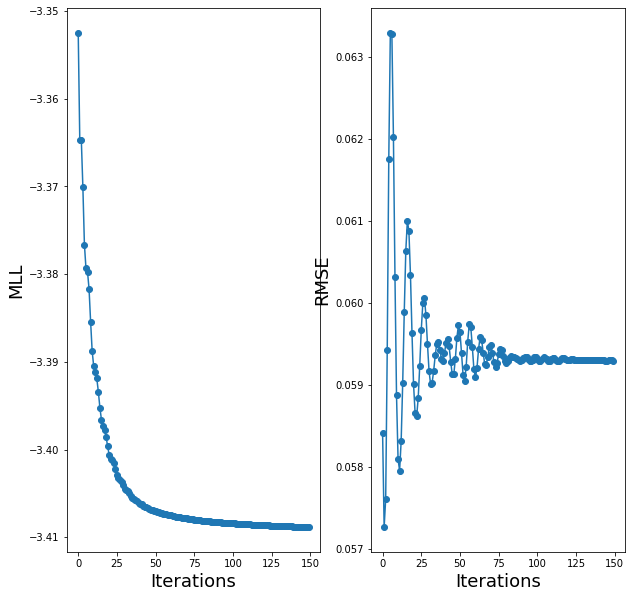

In [35]:
_,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
axs[0].plot(np.arange(training_iter), mll_trajectory,marker='o')
axs[1].plot(np.arange(training_iter), mll_trajectory_tst, marker='o')
axs[0].set_xlabel('Iterations',fontsize=18)
axs[0].set_ylabel('MLL',fontsize=18)
axs[1].set_xlabel('Iterations',fontsize=18)
axs[1].set_ylabel('RMSE', fontsize=18)


In [38]:
# Prediction with GPyTorch
from torch.utils.data import TensorDataset, DataLoader

# 	In all other cases, he suggests using a power of 2 as the mini-batch size.
# 	So the minibatch should be 64, 128, 256, 512, or 1024 elements large.

dummy_test_y = torch.full_like(Xtot, dtype=torch.long, fill_value=0)
test_dataset = TensorDataset(Xtot, dummy_test_y)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

means = torch.tensor([0.])
stds = torch.tensor([[0.,0]])
with torch.no_grad():
	for x_batch, _ in test_loader:
		preds = likelihood(model(x_batch.double().cuda()))
		mean = preds.mean.cpu()
		means = torch.cat([means, mean])
		l,u = preds.confidence_region()
		std = torch.column_stack((l,u))
		stds = torch.vstack((stds,std.cpu()))
        # stds = torch.vstack(stds,std)


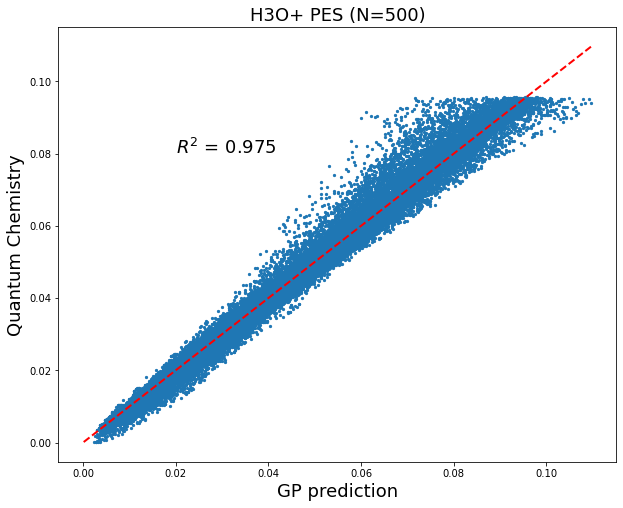

In [45]:
from sklearn.metrics import r2_score

ytot_gp = means[1:].numpy() # torch to numpy 
r2 = r2_score(ytot_gp,ytot)

plt.figure(figsize=(10,8))
plt.scatter(ytot_gp,ytot,s=5)

low = np.min(np.stack((ytot_gp,ytot)).flatten())
high = np.max(np.stack((ytot_gp,ytot)).flatten())
plt.plot([low, high], [low, high], ls="--", c="red",lw=2.)

plt.title('H3O+ PES (N=%s)'%N,fontsize=18)
plt.text(0.02,0.08,r'$R^{2}$ = %.3f'%r2,fontsize=18)
plt.xlabel('GP prediction',fontsize=18)
plt.ylabel('Quantum Chemistry',fontsize=18)
plt.show()

**Exercise**:
1. What happened if you change the learning rate (```lr```) in\
    ```optimizer = torch.optim.Adam(model.parameters(), lr=0.1)```?
2. What happened if we assume a zero mean GPs?\
   ``` self.mean_module = gpytorch.means.ZeroMean()```
3. How significant is the total error if we assume an isotropic RBF kernel?\
   ```self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())```
4. What is the lowest number of geometries where $R^{2}$ is still 0.9?
5. Resample the training data and compare the total error.\
   ```train_test_split(...,random_state=<CHOSE ANOTHER INTEGER>)```
6. Chose a kernel from [list of kernels](https://docs.gpytorch.ai/en/v1.6.0/kernels.html) and compare with the RBF results.


<!-- 
Multiple kernels:
k_rbf = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))
k_mat = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=train_x.shape[1]))
self.covar_module = k_rbf + k_mat
for i in range(2):
    print('lengthscale: ', model.covar_module.kernels[i].base_kernel.lengthscale[0]) -->